In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/Kolmogorov


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories
from tools.ae_v3 import Autoencoder

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-08 01:30:00.013962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 01:30:00.014374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 01:30:00.053428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 01:30:00.053664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 01:30:00.053842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # loading data directory
    data_dir_idx = '000'

    # making ae save directory
    dir_name_ae = os.getcwd() + dir_sep + 'saved_ae'
    if not os.path.isdir(dir_name_ae):
        os.makedirs(dir_name_ae)

    counter = 0
    while True:
        dir_check = 'ae_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae = dir_name_ae + dir_sep + dir_check
    os.makedirs(dir_name_ae)
    os.makedirs(dir_name_ae+dir_sep+'plots')
else:
    # some paramaters
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_015'.format(ds=dir_sep)

    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_ae:', dir_name_ae)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with h5py.File(dir_name_data + '/data.h5', 'r') as f:
    t_recorded_samples = np.array(f['t'])
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))
    
    u_ref = np.array(f['u_reference'], dtype=FTYPE)
    v_ref = np.array(f['v_reference'], dtype=FTYPE)

dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030
24 <class 'int'>


In [13]:
all_data = np.empty(shape=(u_ref.shape[0], 2, u_ref.shape[1], u_ref.shape[2]), dtype=FTYPE)
all_data[:, 0, :, :] = u_ref
del(u_ref)
all_data[:, 1, :, :] = v_ref
del(v_ref)

In [14]:
# dealing with normalizing the data before feeding into autoencoder
if behaviour == 'initialiseAndTrainFromScratch':
    # normalize data before feeding into autoencoder?
    normalizeforae_flag = True
    normalization_type = 'stddev' # could be 'stddev' or 'minmax'
    stddev_multiplier = 3
    
    normalization_constant_arr_aedata = None
    if normalizeforae_flag == True:
        normalization_constant_arr_aedata = np.empty(shape=(2,) + tuple(all_data.shape[1:]), dtype=FTYPE)
        if normalization_type == 'stddev':
            normalization_constant_arr_aedata[0] = np.mean(all_data, axis=0)
            normalization_constant_arr_aedata[1] = stddev_multiplier * np.std(all_data, axis=0)
        elif normalization_type == 'minmax':
            sample_min = all_data.min(axis=0)
            sample_max = all_data.max(axis=0)
            idx = np.where(sample_min == sample_max)
            if len(idx) > 0:
                num_elems = len(idx[0])
                for i in range(num_elems):
                    i0 = idx[0][i]
                    i1 = idx[1][i]
                    i2 = idx[2][i]
                    sample_min[i0, i1, i2] -= 0.5
                    sample_max[i0, i1, i2] = sample_min[i0, i1, i2] + 1.
            normalization_constant_arr_aedata[0] = sample_min
            normalization_constant_arr_aedata[1] = sample_max - sample_min
        all_data -= normalization_constant_arr_aedata[0]
        all_data /= normalization_constant_arr_aedata[1]
            
    # saving sim data
    ae_data = {
        'data_dir_idx':data_dir_idx,
        'normalizeforae_flag':normalizeforae_flag,
        # 'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
        'normalization_type':normalization_type,
        'stddev_multiplier':stddev_multiplier,
        'ae_data_with_params':False,
        'module':Autoencoder.__module__,
    }
    with open(dir_name_ae+dir_sep+'ae_data.txt', 'w') as f:
        f.write(str(ae_data))
    np.savez(
        dir_name_ae+dir_sep+'normalization_data',
        normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
    )
else:
    if normalizeforae_flag == True:
        all_data -= normalization_constant_arr_aedata[0]
        all_data /= normalization_constant_arr_aedata[1]
            
time_stddev = np.std(all_data, axis=0)

In [15]:
all_data = all_data[::4]

# Autoencoder

In [16]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 200
    patience = 10  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 5e-7 # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 16
    fRMS = 2/100
    timeMeanofSpaceRMS = np.mean(np.mean(all_data**2, axis=1)**0.5)
    
    # stddev = fRMS*timeMeanofSpaceRMS
    stddev = fRMS * np.mean(time_stddev)
    use_weights_post_dense = False
    use_batch_norm = True

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'use_batch_norm':use_batch_norm,
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        stddev = tparams_dict['stddev']
    except:
        print("'stddev' not in tparams_dict, set to 0")
        stddev = 0.0

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [17]:
# # setting up data
# idx = np.arange(all_data.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round((1-test_split)*all_data.shape[0]))
# training_data = all_data[idx[0:boundary], :]
# testing_data = all_data[idx[boundary:], :]

In [18]:
num_train = int(all_data.shape[0]*train_split)
num_val = int(all_data.shape[0]*val_split)
num_test = all_data.shape[0] - num_train - num_val

idx = np.arange(all_data.shape[0])
np.random.shuffle(idx)

training_data = np.empty(shape=(num_train, ) + tuple(all_data.shape[1:]), dtype=FTYPE)
val_data = np.empty(shape=(num_val, ) + tuple(all_data.shape[1:]), dtype=FTYPE)
testing_data = np.empty(shape=(num_test, ) + tuple(all_data.shape[1:]), dtype=FTYPE)

training_data[:] = all_data[idx[0:num_train]]
val_data[:] = all_data[idx[num_train:num_train+num_val]]
testing_data[:] = all_data[idx[num_train+num_val:]]

In [19]:
del(all_data)

In [20]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    enc_filters = [8, 16, 32, 2] # [8, 3, 1]
    enc_strides = [2, 2, 2, 2] # [2, 1, 1]
    enc_attn_placement = [1, 2, 3]
    dec_filters = [32, 16, 8, 2]# [3, 8, 2]
    dec_strides = [2, 2, 2, 2] # [1, 1, 2]
    dec_attn_placement = [0, 1]
    kernel_size = 3
    
    enc_layer_act_func = 'elu'
    enc_final_layer_act_func = 'tanh'
    dec_layer_act_func = 'elu'
    dec_final_layer_act_func = 'tanh'
    reg_name = 'L2'
    
    use_periodic_padding = True
    use_attention_module = False
    
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(
                data_dim=training_data.shape[1:],
                kernel_size=kernel_size,
                enc_filters=enc_filters, # number of filters
                dec_filters=dec_filters, # number of filters
                lambda_reg=lambda_reg,
                reg_name=reg_name,
                enc_layer_act_func=enc_layer_act_func,
                enc_final_layer_act_func=enc_final_layer_act_func,
                dec_layer_act_func=dec_layer_act_func,
                dec_final_layer_act_func=dec_final_layer_act_func,
                load_file=None,
                stddev=stddev,
                use_weights_post_dense=use_weights_post_dense,
                use_batch_norm=use_batch_norm,
                use_periodic_padding=use_periodic_padding,
                use_attention_module=use_attention_module,
                enc_strides=enc_strides,
                enc_attn_placement=enc_attn_placement,
                dec_strides=dec_strides,
                dec_attn_placement=dec_attn_placement,)
    else:
        ae_net = Autoencoder(
            data_dim=training_data.shape[1:],
            kernel_size=kernel_size,
            enc_filters=enc_filters, # number of filters
            dec_filters=dec_filters, # number of filters
            lambda_reg=lambda_reg,
            reg_name=reg_name,
            enc_layer_act_func=enc_layer_act_func,
            enc_final_layer_act_func=enc_final_layer_act_func,
            dec_layer_act_func=dec_layer_act_func,
            dec_final_layer_act_func=dec_final_layer_act_func,
            load_file=None,
            stddev=stddev,
            use_weights_post_dense=use_weights_post_dense,
            use_batch_norm=use_batch_norm,
            use_periodic_padding=use_periodic_padding,
            use_attention_module=use_attention_module,
            enc_strides=enc_strides,
            enc_attn_placement=enc_attn_placement,
            dec_strides=dec_strides,
            dec_attn_placement=dec_attn_placement,)
    # saving the AE configuration
    save_path = dir_name_ae+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    ae_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ae + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(data_dim=training_data.shape[1:], load_file=load_file)
    else:
        ae_net = Autoencoder(data_dim=training_data.shape[1:], load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ae+dir_sep+'checkpoints')
        # ae_net.load_weights(wt_file)
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
        ae_net.load_weights_from_file(wt_file)

0 / 4
1 / 4
2 / 4
3 / 4
(69, 69)


2023-06-08 01:30:09.408314: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


In [21]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [22]:
train_MSE_hist = []
val_MSE_hist = []

train_NMSE_hist = []
val_NMSE_hist = []

if use_attention_module == True:
    encoder_attention_lambdas = {}
    for i in range(len(ae_net.encoder_attention_modules_list)):
        l = ae_net.encoder_attention_modules_list[i]
        encoder_attention_lambdas['encoder_attention_module_{}_lambda'.format(i)] = [0]
    decoder_attention_lambdas = {}
    for i in range(len(ae_net.decoder_attention_modules_list)):
        l = ae_net.decoder_attention_modules_list[i]
        decoder_attention_lambdas['decoder_attention_module_{}_lambda'.format(i)] = [0]

In [23]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [24]:
if strategy is not None:
    with strategy.scope():
        NMSE_metric = NMSE(divisor_arr=tf.constant(time_stddev))
else:
    NMSE_metric = NMSE(divisor_arr=tf.constant(time_stddev))

In [25]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
#     loss=losses.BinaryCrossentropy(from_logits=False),
    run_eagerly=False,
    metrics=['mse', NMSE_metric]
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            ae_net.load_weights(wt_file)
    else:
        ae_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=1  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ae_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ae_net.fit(training_data, training_data,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data, val_data),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])
        
        if use_attention_module == True:
            for j in range(len(ae_net.encoder_attention_modules_list)):
                key = 'encoder_attention_module_{}_lambda'.format(j)
                lst1 = history.history[key]
                lst2 = encoder_attention_lambdas[key]
                lst2.extend(lst1)
                encoder_attention_lambdas[key] = lst2
            for j in range(len(ae_net.decoder_attention_modules_list)):
                key = 'decoder_attention_module_{}_lambda'.format(j)
                lst1 = history.history[key]
                lst2 = decoder_attention_lambdas[key]
                lst2.extend(lst1)
                decoder_attention_lambdas[key] = lst2
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
1248/1250 [============================>.] - ETA: 0s - loss: 0.0456 - mse: 0.0456 - NMSE: 0.4105 - tot_time: 0h 0m 15.4s

Epoch 1: val_NMSE improved from inf to 0.18934, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 14s 10ms/step - loss: 0.0456 - mse: 0.0456 - NMSE: 0.4102 - val_loss: 0.0211 - val_mse: 0.0210 - val_NMSE: 0.1893
Epoch 2/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0196 - mse: 0.0196 - NMSE: 0.1762 - tot_time: 0h 0m 27.4s

Epoch 2: val_NMSE improved from 0.18934 to 

Epoch 15/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0118 - mse: 0.0118 - NMSE: 0.1058 - tot_time: 0h 3m 5.6s

Epoch 15: val_NMSE improved from 0.10036 to 0.10008, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0118 - mse: 0.0118 - NMSE: 0.1058 - val_loss: 0.0112 - val_mse: 0.0111 - val_NMSE: 0.1001
Epoch 16/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0117 - mse: 0.0116 - NMSE: 0.1047 - tot_time: 0h 3m 18.0s

Epoch 16: val_NMSE improved from 0.10008 to 0.09981, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint


1250/1250 [==============================] - ETA: 0s - loss: 0.0109 - mse: 0.0108 - NMSE: 0.0973 - tot_time: 0h 6m 9.8s

Epoch 30: val_NMSE improved from 0.09252 to 0.09200, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0109 - mse: 0.0108 - NMSE: 0.0973 - val_loss: 0.0104 - val_mse: 0.0102 - val_NMSE: 0.0920
Epoch 31/200
1246/1250 [============================>.] - ETA: 0s - loss: 0.0109 - mse: 0.0108 - NMSE: 0.0968 - tot_time: 0h 6m 21.9s

Epoch 31: val_NMSE did not improve from 0.09200
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0109 - mse: 0.0108 - NMSE: 0.0968 - val_loss: 0.0105 

Epoch 46/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0106 - mse: 0.0104 - NMSE: 0.0939 - tot_time: 0h 9m 25.1s

Epoch 46: val_NMSE did not improve from 0.08808
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0106 - mse: 0.0104 - NMSE: 0.0940 - val_loss: 0.0100 - val_mse: 0.0099 - val_NMSE: 0.0887
Epoch 47/200
1246/1250 [============================>.] - ETA: 0s - loss: 0.0106 - mse: 0.0104 - NMSE: 0.0938 - tot_time: 0h 9m 37.2s

Epoch 47: val_NMSE did not improve from 0.08808
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0106 - mse: 0.0104 - NMSE: 0.0939 - val_loss: 0.0100 - val_mse: 0.0098 - val_NMSE: 0.0886
Epoch 48/200
1248/1250 [============================>.] - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0104 - mse: 0.0102 - NMSE: 0.0922 - val_loss: 0.0098 - val_mse: 0.0096 - val_NMSE: 0.0866
Epoch 63/200
1246/1250 [============================>.] - ETA: 0s - loss: 0.0104 - mse: 0.0102 - NMSE: 0.0921 - tot_time: 0h 12m 52.5s

Epoch 63: val_NMSE did not improve from 0.08659
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0104 - mse: 0.0102 - NMSE: 0.0921 - val_loss: 0.0099 - val_mse: 0.0098 - val_NMSE: 0.0878
Epoch 64/200
1246/1250 [============================>.] - ETA: 0s - loss: 0.0104 - mse: 0.0102 - NMSE: 0.0920 - tot_time: 0h 13m 4.8s

Epoch 64: val_NMSE did not improve from 0.08659
 - saving loss histories at /home/rkaushik/Documents/Thes

Epoch 79/200
1248/1250 [============================>.] - ETA: 0s - loss: 0.0103 - mse: 0.0101 - NMSE: 0.0909 - tot_time: 0h 16m 6.2s

Epoch 79: val_NMSE did not improve from 0.08538
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0103 - mse: 0.0101 - NMSE: 0.0909 - val_loss: 0.0098 - val_mse: 0.0096 - val_NMSE: 0.0865
Epoch 80/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0103 - mse: 0.0101 - NMSE: 0.0911 - tot_time: 0h 16m 18.4s

Epoch 80: val_NMSE did not improve from 0.08538
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0103 - mse: 0.0101 - NMSE: 0.0911 - val_loss: 0.0098 - val_mse: 0.0096 - val_NMSE: 0.0863
Epoch 81/200
1247/1250 [============================>.] -

Epoch 96/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0103 - mse: 0.0100 - NMSE: 0.0903 - tot_time: 0h 19m 32.4s

Epoch 96: val_NMSE did not improve from 0.08423
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0103 - mse: 0.0100 - NMSE: 0.0903 - val_loss: 0.0098 - val_mse: 0.0096 - val_NMSE: 0.0865
Epoch 97/200
1248/1250 [============================>.] - ETA: 0s - loss: 0.0103 - mse: 0.0100 - NMSE: 0.0903 - tot_time: 0h 19m 44.4s

Epoch 97: val_NMSE did not improve from 0.08423
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0102 - mse: 0.0100 - NMSE: 0.0903 - val_loss: 0.0096 - val_mse: 0.0094 - val_NMSE: 0.0844
Epoch 98/200
1245/1250 [============================>.] 

Epoch 112: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
1244/1250 [============================>.] - ETA: 0s - loss: 0.0100 - mse: 0.0097 - NMSE: 0.0876 - tot_time: 0h 23m 6.6s

Epoch 1: val_NMSE improved from 0.08368 to 0.08182, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 13s 11ms/step - loss: 0.0100 - mse: 0.0097 - NMSE: 0.0876 - val_loss: 0.0093 - val_mse: 0.0091 - val_NMSE: 0.0818
Epoch 2/200
1246/1250 [============================>.] - ETA: 0s - loss: 0.0099 - mse: 0.0097 - NMSE: 0.0875 - tot_time: 0h 23m 19.5s

Epoch 2: val

1250/1250 [==============================] - ETA: 0s - loss: 0.0099 - mse: 0.0097 - NMSE: 0.0872 - tot_time: 0h 26m 20.6s

Epoch 16: val_NMSE did not improve from 0.08143
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 13s 10ms/step - loss: 0.0099 - mse: 0.0097 - NMSE: 0.0872 - val_loss: 0.0093 - val_mse: 0.0090 - val_NMSE: 0.0814
Epoch 17/200
1247/1250 [============================>.] - ETA: 0s - loss: 0.0099 - mse: 0.0097 - NMSE: 0.0872 - tot_time: 0h 26m 33.7s

Epoch 17: val_NMSE did not improve from 0.08143
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 13s 10ms/step - loss: 0.0099 - mse: 0.0097 - NMSE: 0.0872 - val_loss: 0.0093 - val_mse: 0.0091 - val_NMSE: 0.0815
Epoch 18/200
1247/1250 [============================>.] - ETA: 0s - l

Epoch 33/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0099 - mse: 0.0097 - NMSE: 0.0871 - tot_time: 0h 30m 2.0s

Epoch 33: val_NMSE did not improve from 0.08125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 13s 11ms/step - loss: 0.0099 - mse: 0.0097 - NMSE: 0.0871 - val_loss: 0.0092 - val_mse: 0.0090 - val_NMSE: 0.0813
Epoch 34/200
1248/1250 [============================>.] - ETA: 0s - loss: 0.0099 - mse: 0.0097 - NMSE: 0.0870 - tot_time: 0h 30m 15.0s

Epoch 34: val_NMSE improved from 0.08125 to 0.08123, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 13s 10ms/step - loss: 0.0099 - mse: 0.0097 - NMSE: 0.0870 - va

Epoch 50/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0099 - mse: 0.0097 - NMSE: 0.0869 - tot_time: 0h 33m 34.0s

Epoch 50: val_NMSE did not improve from 0.08112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0099 - mse: 0.0097 - NMSE: 0.0869 - val_loss: 0.0092 - val_mse: 0.0090 - val_NMSE: 0.0813
Epoch 51/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0099 - mse: 0.0096 - NMSE: 0.0868 - tot_time: 0h 33m 46.2s

Epoch 51: val_NMSE did not improve from 0.08112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0099 - mse: 0.0096 - NMSE: 0.0868 - val_loss: 0.0092 - val_mse: 0.0090 - val_NMSE: 0.0812
Epoch 52/200
1245/1250 [============================>.] 

Epoch 13/200
1246/1250 [============================>.] - ETA: 0s - loss: 0.0098 - mse: 0.0096 - NMSE: 0.0867 - tot_time: 0h 36m 50.3s

Epoch 13: val_NMSE did not improve from 0.08088
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0098 - mse: 0.0096 - NMSE: 0.0866 - val_loss: 0.0092 - val_mse: 0.0090 - val_NMSE: 0.0809
Epoch 14/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0098 - mse: 0.0096 - NMSE: 0.0866 - tot_time: 0h 37m 2.5s

Epoch 14: val_NMSE did not improve from 0.08088
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_030/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0098 - mse: 0.0096 - NMSE: 0.0866 - val_loss: 0.0092 - val_mse: 0.0090 - val_NMSE: 0.0809
Epoch 15/200
1247/1250 [============================>.] -

In [26]:
from io import StringIO
import sys

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self

    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio
        sys.stdout = self._stdout

In [27]:
with Capturing() as output:
    ae_net.encoder_net.summary()

with open(dir_name_ae + '/ae_encoder_summary.txt', 'w') as f:
    for line in output:
        f.write(line + '\n')

In [28]:
with Capturing() as output:
    ae_net.decoder_net.summary()

with open(dir_name_ae + '/ae_decoder_summary.txt', 'w') as f:
    for line in output:
        f.write(line + '\n')

In [29]:
ae_net.ae_net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2, 50, 50)]       0         
                                                                 
 model (Functional)          (None, 2, 4, 4)           13778     
                                                                 
 model_1 (Functional)        (None, 2, 50, 50)         9672      
                                                                 
Total params: 23,450
Trainable params: 13,192
Non-trainable params: 10,258
_________________________________________________________________


In [30]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_metrics = ae_net.evaluate(
        testing_data, testing_data,
    )
#     train_metrics = ae_net.evaluate(training_data, training_data)
#     val_metrics = ae_net.evaluate(val_data, val_data)

    save_path = dir_name_ae+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    save_dict = {
        'val_loss_hist':val_loss_hist,
        'train_loss_hist':train_loss_hist,
        'val_MSE_hist':val_MSE_hist,
        'train_MSE_hist':train_MSE_hist,
        'val_NMSE_hist':val_NMSE_hist,
        'train_NMSE_hist':train_NMSE_hist,
        'lr_change':lr_change,
        'test_loss':test_metrics[0],
        'test_mse':test_metrics[1],
#         'train_loss':train_metrics[0],
#         'train_mse':train_metrics[1],
#         'val_loss':val_metrics[0],
#         'val_mse':val_metrics[1],
    }
    if use_attention_module == True:
        for i in range(len(ae_net.encoder_attention_modules_list)):
            key = 'encoder_attention_module_{}_lambda'.format(i)
            save_dict[key] = encoder_attention_lambdas[key]
        for i in range(len(ae_net.decoder_attention_modules_list)):
            key = 'decoder_attention_module_{}_lambda'.format(i)
            save_dict[key] = decoder_attention_lambdas[key]

    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str(save_dict))

    np.savez(
        save_path+dir_sep+'losses',
        **save_dict
    )
        

    ae_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

79/79 [==============================] - 1s 10ms/step - loss: 0.0093 - mse: 0.0091 - NMSE: 0.0821


In [31]:
print('lr_change : ', lr_change)

lr_change :  [0, 112, 165, 186]


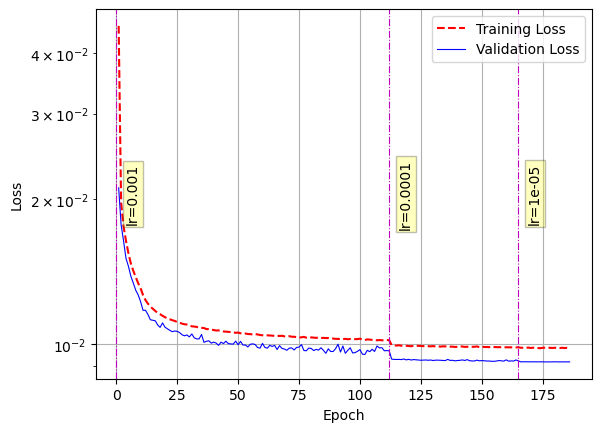

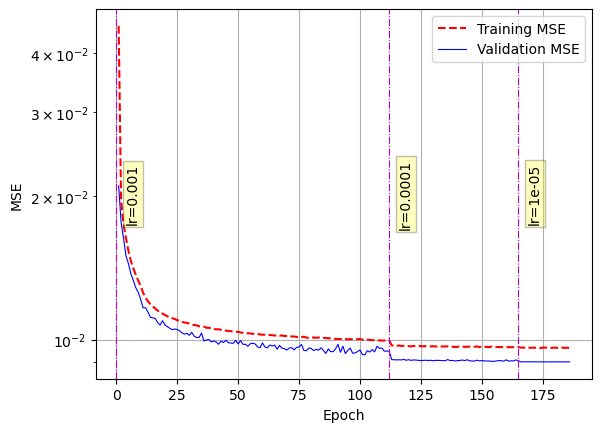

<Figure size 640x480 with 0 Axes>

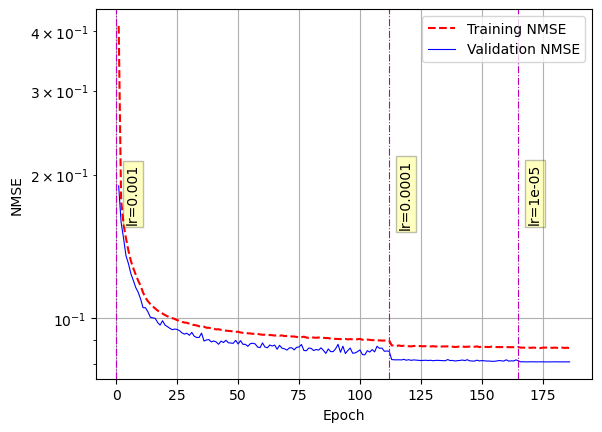

<Figure size 640x480 with 0 Axes>

In [32]:
# plotting losses
dir_name_plot = dir_name_ae + '/plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_plot + '{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

In [33]:
if use_attention_module == True:
    # plotting encoder attention lambdas
    plot_lst = []
    legend_lst = []
    for i in range(len(ae_net.encoder_attention_modules_list)):
        key = 'encoder_attention_module_{}_lambda'.format(i)
        plot_lst.append(encoder_attention_lambdas[key])
        legend_lst.append("attention module (encoder) {}".format(i+1))
    fig, ax = plot_losses(
        training_loss=plot_lst[0],
        val_loss=None,
        more_plot_arrs_lst=plot_lst[1:] if len(plot_lst)>1 else [],
        lr_change=lr_change,
        learning_rate_list=learning_rate_list,
        legend_list=legend_lst,
        xlabel='Epoch',
        ylabel=r"$\lambda_{attention}$",
        plot_type='plot',
        traininglossplot_args=[],
        traininglossplot_kwargs={},
        epoch_count_begin=0,
        epoch_count_end=len(plot_lst[0])-1,
    )
    plt.savefig(dir_name_plot+'/attention_lambdas_encoder.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()
    
    # plotting decoder attention lambdas
    plot_lst = []
    legend_lst = []
    for i in range(len(ae_net.decoder_attention_modules_list)):
        key = 'decoder_attention_module_{}_lambda'.format(i)
        plot_lst.append(decoder_attention_lambdas[key])
        legend_lst.append("attention module (decoder) {}".format(i+1))
    fig, ax = plot_losses(
        training_loss=plot_lst[0],
        val_loss=None,
        more_plot_arrs_lst=plot_lst[1:] if len(plot_lst)>1 else [],
        lr_change=lr_change,
        learning_rate_list=learning_rate_list,
        legend_list=legend_lst,
        xlabel='Epoch',
        ylabel=r"$\lambda_{attention}$",
        plot_type='plot',
        traininglossplot_args=[],
        traininglossplot_kwargs={},
        epoch_count_begin=0,
        epoch_count_end=len(plot_lst[0])-1,
    )
    plt.savefig(dir_name_plot+'/attention_lambdas_decoder.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()

# POD Comparison

In [34]:
# pod_training_data = np.empty(shape=(training_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]))
# pod_training_data[:, :] = np.reshape(training_data, (training_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]))

# pod_centering_means = np.mean(pod_training_data, axis=0)
# pod_mean_centered_data = pod_training_data - pod_centering_means

In [35]:
# C = np.transpose(pod_mean_centered_data) @ pod_mean_centered_data
# C /= pod_mean_centered_data.shape[0] - 1

In [36]:
# eigenvals, eigenvecs = np.linalg.eig(C)

In [37]:
# abs_eigenvals = np.abs(eigenvals)
# idx = np.argsort(abs_eigenvals)

In [38]:
# idx = idx[::-1]
# W = eigenvecs[:, idx[0:4*4*enc_filters[-1]]]

In [39]:
# reconstructed_val_data = val_data.reshape(val_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]) @ W @ W.transpose()
# reconstructed_val_data = np.reshape(reconstructed_val_data, val_data.shape)

In [40]:
# val_recon_MSE = np.reshape((reconstructed_val_data - val_data)**2, (val_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]))
# val_recon_MSE = np.mean(np.sum(val_recon_MSE, axis=1), axis=0)

In [41]:
# print(val_recon_MSE, val_recon_MSE/np.sum(time_stddev**2), np.sum(time_stddev**2))

In [42]:
# abs_eigenvals[idx[0:4*4*2]]

In [43]:
s = ''
for i in range(len(ae_net.encoder_layers_list)):
    l = ae_net.encoder_layers_list[i]
    name = str(l.name)
    if name.startswith('attention_module'):
        # print(i, name, l.lambda_att.numpy())
        s += 'i : {}, name : {}, lambda_att : {}\n'.format(i, name, l.lambda_att.numpy())
print(s)

if s != '':
    with open(dir_name_ae + '/attention_lambdas_encoder.txt', 'w') as f:
        f.write(s)

In [44]:
s = ''
for i in range(len(ae_net.decoder_layers_list)):
    l = ae_net.decoder_layers_list[i]
    name = str(l.name)
    if name.startswith('attention_module'):
        # print(i, name, l.lambda_att.numpy())
        s += 'i : {}, name : {}, lambda_att : {}\n'.format(i, name, l.lambda_att.numpy())
print(s)

if s != '':
    with open(dir_name_ae + '/attention_lambdas_decoder.txt', 'w') as f:
        f.write(s)

In [45]:
for i in range(len(ae_net.encoder_layers_list)):
    l = ae_net.encoder_layers_list[i]
    name = str(l.name)
    if name.startswith('periodic_padding'):
        print(i, name, l.M_mat)

0 periodic_padding <tf.Variable 'periodic_padding/M_mat:0' shape=(52, 50) dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)>
4 periodic_padding_1 <tf.Variable 'periodic_padding_1/M_mat:0' shape=(27, 25) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

In [46]:
for i in range(len(ae_net.decoder_layers_list)):
    l = ae_net.decoder_layers_list[i]
    name = str(l.name)
    if name.startswith('periodic_padding'):
        print(i, name, l.M_mat)

0 periodic_padding_4 <tf.Variable 'periodic_padding_4/M_mat:0' shape=(6, 4) dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)>
5 periodic_padding_5 <tf.Variable 'periodic_padding_5/M_mat:0' shape=(10, 8) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>
10 periodic_padding_6 <tf.Variable 'periodic_padding_6/M_mat:0' shape=(18, 16) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.,